## $\color{red}{\text{Lecture Overview}}$
1. **k-Nearest Nieghbor Regression**
2. **Developing the Analytic Task**
3. **Data Transformation**
4. **Data Visualization**
5. **Data Modeling**

## $\color{red}{\text{k-Nearest Neighbor}}$

### $\color{blue}{\text{An Intuition}}$
1. Some data points are similar, while others are not
    - **Similarity** is measured as distance between data points
    - Similar observations are called **neighbors**
2. Similar points are likely to share similar class labels

### $\color{blue}{\text{Training a kNN Model}}$

1. For a new point in the testing data
    - Identify $k$ neighboring points in the training data
2. The new observation in the testing data is the average of the neighboring points

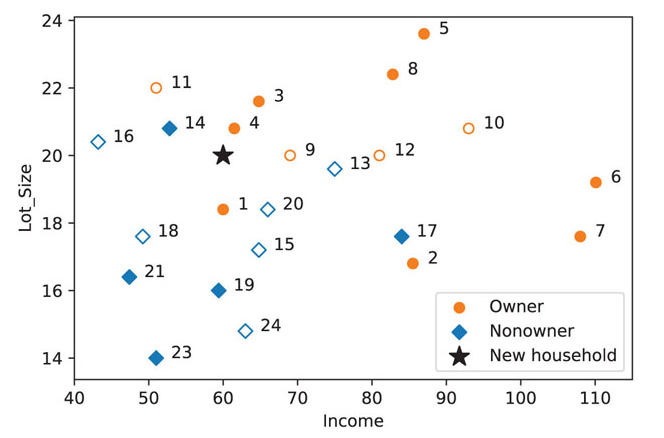

## $\color{red}{\text{Import Required Packages}}$

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt

## $\color{red}{\text{Import Data}}$

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/DS4510/Data
housingData= pd.read_excel('housingData.xlsx', sheet_name='housingData')

/content/drive/MyDrive/DS4510/Data


## $\color{red}{\text{Analytic Task}}$
1. Using the housing data, build a **DT/RF regression model** to predict **price**
2. Perform data transformation methods wherever needed
3. Perform data visualization tasks to develop a preliminary understanding of **price**
4. Develop a model to predict **price**
5. Assess the robustness of the model
6. Interpret the model for insights

## $\color{red}{\text{Data Transformation}}$


### $\color{blue}{\text{Missing Value Analysis}}$

- Check missing values in the data

In [ ]:
# Function to compute missing values
def percent_missing(data):
    return data.isnull().sum().divide(len(data)).sort_values(ascending=False)

# Using the function
percent_missing(housingData).head()

,0
id,0.0
date,0.0
bedrooms,0.0
bathrooms,0.0
sqft_living,0.0


### $\color{blue}{\text{Multicollinearity}}$

1. Using a correlation plot, find variables with strong association with the dependent variable, **price**
2. **Multicollinearity** occurs when variables have similar information
    - Variables with a correlation greater than 0.70 are considered to have similar information
    - One of the variables should not be included in the analysis
3. Which variables are closely related to each other?

In [ ]:
#!pip install dython
from dython.nominal import associations
import seaborn as sns

def corrPlot(data):

  # Use "associations" function to compute correlation between all variables
  corr_matrix = associations(dataset=data, compute_only=True)['corr']

  # Mask the upper triangle of correlation heatmap
  mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

  # Plotting correlation heatmap
  plt.figure(figsize=(12, 8))
  sns.heatmap(corr_matrix, annot=True, mask=mask_upper, cmap='coolwarm_r', fmt='.2f', vmin=-1, vmax=1)
  plt.show()

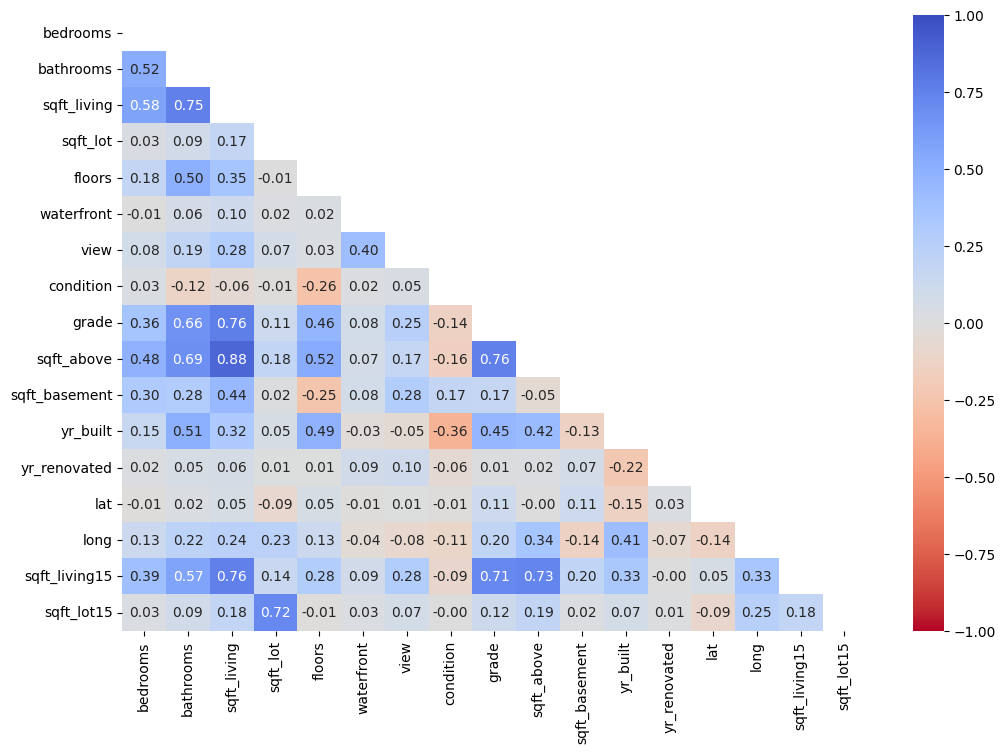

In [ ]:
# Drop the following variables from the data, as they are not needed for the analysis
drop_vars = ["id", "date", "zipcode", 'price']
new_housing = housingData.drop(drop_vars, axis=1)

# Use function to plot correlation heatmap
corrPlot(data=new_housing)

### $\color{blue}{\text{Removing Colinear Variables}}$
- If correlation between variables are greater than 0.7, one of the variables should be removed

In [ ]:
'''
This function drops highly correlated variables given a threshold.
It drops the variable with smaller variance
'''

def drop_highly_correlated(data, threshold):
    cor_matrix = data.corr().abs()
    sol = (cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))).unstack().dropna()

    to_drop=[]
    for i in range(len(sol[sol > threshold].index.tolist())):
        var1 = sol[sol >= threshold].index.tolist()[i][0]
        var2 = sol[sol >= threshold].index.tolist()[i][1]

        if(data[var1].var() < data[var2].var()): to_drop.append(var1)
        else: to_drop.append(var2)

    dropped_vars = list(set(to_drop))
    return dropped_vars, data.drop(dropped_vars, axis=1)

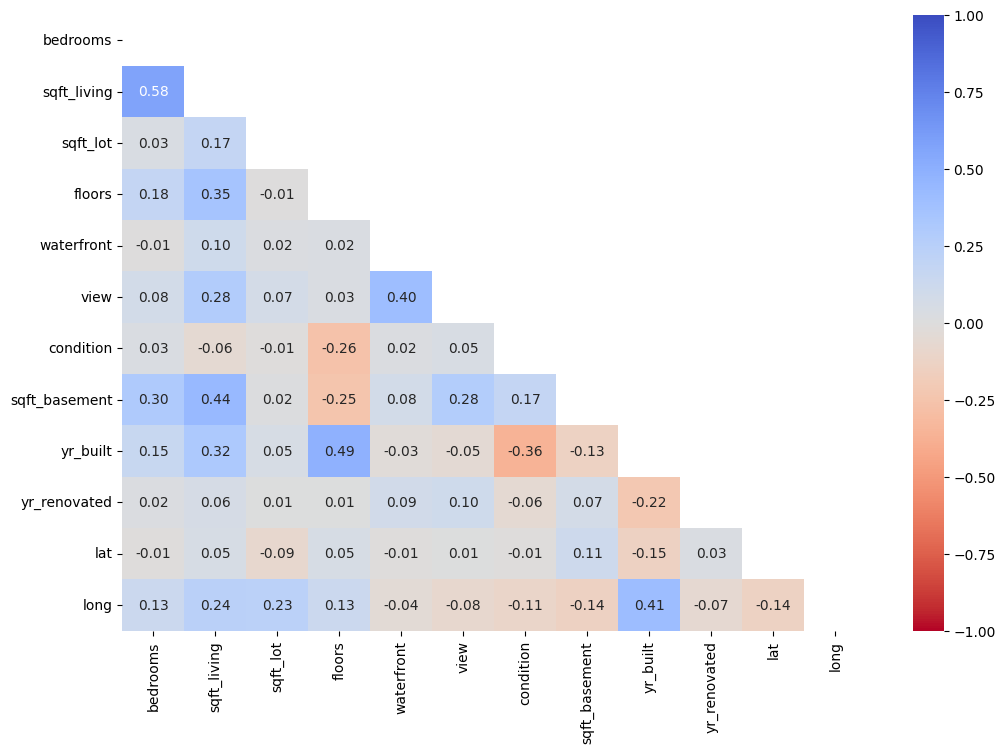

In [ ]:
# Drop the following variables from the data, as they are not needed for the analysis
drop_vars = ["id", "date", "zipcode", 'price']
new_housing = housingData.drop(drop_vars, axis=1)

# Use the function to remove variables with high correlation
dropped_vars, new_housing_v2 = drop_highly_correlated(data=new_housing, threshold=0.7)

# Plot the correlation of the resulting data
corrPlot(data=new_housing_v2)

### $\color{blue}{\text{Removing Near Zero-Variance Variables}}$
- Some variables have little or no variation. They do not add much value to the model

In [ ]:
from sklearn.feature_selection import VarianceThreshold

vThreshold = VarianceThreshold(threshold = 0.1)
vThreshold.fit_transform(new_housing_v2)

# Get variables with greater variance
vars = new_housing_v2.columns[vThreshold.get_support()]

# Subset data for variables with greater variance
housing_varDf = new_housing_v2[vars]

### $\color{blue}{\text{Standardization}}$

- To reduce the effect of outliers

In [ ]:
from sklearn.preprocessing import StandardScaler

#Standarize data
housing_std = StandardScaler().fit_transform(housing_varDf)
housing_std = pd.DataFrame(housing_std, columns=housing_varDf.columns)

#Bring dependent variables to the standardized data
housing_std_full = pd.concat([housing_std, housingData['price']], axis=1)

### $\color{blue}{\text{Data Partitioning}}$

1. Identify dependent and independent variables
2. Partition the data such that 80% is used for training and 20% is used for testing

In [ ]:
from sklearn.model_selection import train_test_split

# Identify dependent and independent variables used in multiple linear regression
indVar = housing_std_full
depVar = housing_std_full['price']

# Partition data into training and testing sets
trainX,testx, trainy,testy = train_test_split(indVar, depVar, train_size=0.8, random_state=100)

### $\color{blue}{\text{Model Fitting and Result}}$

In [ ]:
#!pip install dmba
from sklearn.neighbors import KNeighborsRegressor

#Creating KNN regression moddel
knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1).fit(trainX, trainy)

### $\color{blue}{\text{Model Predictions}}$

- Using the **testing data**, predict the **Price**
  - This is prediction on unseen data

In [ ]:
#Get the prediction for KNN
knn_pred = knn_model.predict(testx)

## $\color{red}{\text{Model Diagnostics}}$

### $\color{blue}{\text{QQ Plot}}$

In [ ]:
import statsmodels.api as sm
import scipy.stats as stats
knn_res = testy - knn_pred

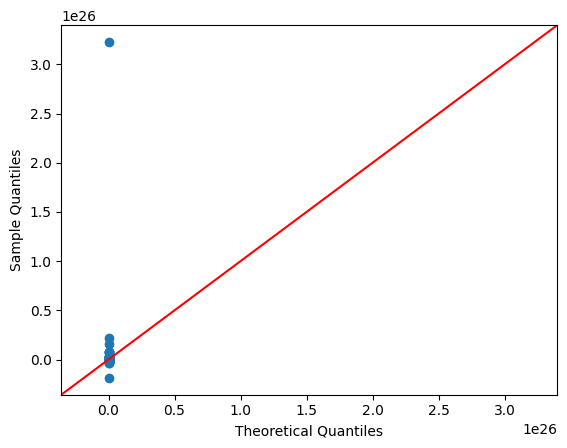

In [ ]:
fig = sm.qqplot(knn_res, stats.t, fit=True, line='45')
plt.show()

### $\color{blue}{\text{Error Calculations}}$

- Mean Error (ME), Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE), Mean Percentage Error (MPE)
- Mean Absolute Percentage Error (MAPE)

In [ ]:
!pip install dmba
from dmba import regressionSummary

In [ ]:
regressionSummary(testy,knn_pred)


Regression statistics

                      Mean Error (ME) : 230.7999
       Root Mean Squared Error (RMSE) : 13749.1003
            Mean Absolute Error (MAE) : 336.1150
          Mean Percentage Error (MPE) : 0.0030
Mean Absolute Percentage Error (MAPE) : 0.0151
